In [1]:

import numpy as np
import pandas as pd

import torch
from datasets import load_dataset
from torch import nn
from tqdm import tqdm, trange
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from torch.utils.data import DataLoader
import pickle
from aiirw import AI_IRW

from scipy.spatial.distance import mahalanobis, cdist

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

/Users/g0bel1n/opt/anaconda3/envs/nlpensae-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("fabriceyhc/bert-base-uncased-imdb")

model = AutoModelForSequenceClassification.from_pretrained("fabriceyhc/bert-base-uncased-imdb")


Found cached dataset imdb (/home/onyxia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset sst2 (/home/onyxia/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset = load_dataset("imdb")
out_dataset = load_dataset("sst2")

In [3]:
class LatentBert(nn.Module):

    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.N = len(self.base_model.bert.encoder.layer)

    def to(self, device):
        self.base_model.to(device)
        return self

    def forward(self, x, return_class = False):
        x = self.base_model.bert.embeddings(x)
        latent_reps = torch.zeros((x.shape[0], x.shape[2],self.N)
        )
        for i, layer in enumerate(self.base_model.bert.encoder.layer) :
            x = layer(x)[0]
            latent_reps[:,:,i] = x[:,0,:] #Pooling is done by taking the hidden state of first token (cf Bert implementation)

        if return_class:
            x = self.base_model.bert.pooler(x)
            x = self.base_model.classifier(x)
            
            return torch.mean(latent_reps, axis=-1), torch.argmax(x, axis=-1)
            
        return torch.mean(latent_reps, axis=-1)

In [4]:
lb = LatentBert(base_model=model).to('cuda')

In [6]:
train_in_dl = DataLoader(dataset['train'], batch_size=8)

environ 14min

In [7]:
embds = []
labels = []
for batch in tqdm(train_in_dl):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    embd, label = lb.forward(tk_batch, return_class=True)
    embds.append(embd.cpu().detach())
    labels.append(label.cpu().detach())

100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


In [8]:
with open('embeddings_train.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('labels_train.pkl', 'wb') as f:
    pickle.dump(labels, f)
    

In [5]:
ood_dl = DataLoader(dataset=out_dataset['test'], batch_size=16)

In [6]:
embds = []
labels = []
is_accurate = []
for batch in tqdm(ood_dl):
    data = batch['sentence']
    true_label = batch['label']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    embd, label = lb.forward(tk_batch, return_class=True)
    embds.append(embd.cpu().detach())
    pred = label.cpu().detach()
    labels.append(pred)
    is_accurate.append(true_label==pred)
    

100%|██████████| 114/114 [00:05<00:00, 21.34it/s]


In [7]:
with open('embeddings_ood_test.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('labels_ood_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [9]:
test_in_dl = DataLoader(dataset['test'], batch_size=8)

environ 14 min

In [10]:
embds = []
labels = []
is_accurate
for batch in tqdm(test_in_dl):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    embd, label = lb.forward(tk_batch, return_class=True)
    embds.append(embd.cpu().detach())
    labels.append(label.cpu().detach())

100%|██████████| 3125/3125 [14:54<00:00,  3.50it/s]


In [11]:
with open('embeddings_test.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('labels_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

## Loading

In [2]:
with open('embeddings_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('labels_train.pkl', 'rb') as f:
    label_train = pickle.load(f)

In [3]:
with open('embeddings_ood_test.pkl', 'rb') as f:
    embd_ood = pickle.load(f)

with open('labels_ood_test.pkl', 'rb') as f:
    label_ood = pickle.load(f)

In [4]:
with open('embeddings_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('labels_test.pkl', 'rb') as f:
    label_test = pickle.load(f)

In [5]:
label_train = torch.cat(label_train).numpy()
embd_train = torch.cat(embd_train).numpy()

train_distrib  = {l: embd_train[np.where(label_train==l)] for l in np.unique(label_train)}


In [6]:
label_test = torch.cat(label_test).numpy()
embd_test = torch.cat(embd_test).numpy()

test_distrib  = {l: embd_test[np.where(label_test==l)] for l in np.unique(label_test)}


In [7]:
label_ood_ = torch.cat(label_ood).numpy()
embd_ood_ = torch.cat(embd_ood).numpy()

ood_distrib  = {l: embd_ood_[np.where(label_ood_==l)] for l in np.unique(label_ood_)}


In [8]:
def MahaDist(X, distrib):
    m = np.mean(distrib, axis=0).reshape(1, 768)
    VI= np.linalg.inv(np.cov(distrib.T))
    return cdist(XA = X, XB = m, metric = 'mahalanobis', VI=VI)

In [9]:
scores_ood = np.concatenate((AI_IRW(X=train_distrib[0], AI=True, X_test=ood_distrib[0], n_dirs=1000) ,AI_IRW(X=train_distrib[1], AI=True, X_test=ood_distrib[1], n_dirs=1000)))
#scores_ood = np.concatenate((MahaDist(X=ood_distrib[0], distrib=train_distrib[0]) ,MahaDist(X=ood_distrib[1], distrib=train_distrib[0])))[:,0]

In [10]:
scores_test = np.concatenate((AI_IRW(X=train_distrib[0], AI=True, X_test=test_distrib[0], n_dirs=1000) ,AI_IRW(X=train_distrib[1], AI=True, X_test=test_distrib[1], n_dirs=1000)))
#scores_test = np.concatenate((MahaDist(X=test_distrib[0], distrib=train_distrib[0]) ,MahaDist(X=test_distrib[1], distrib=train_distrib[1])))[:,0]


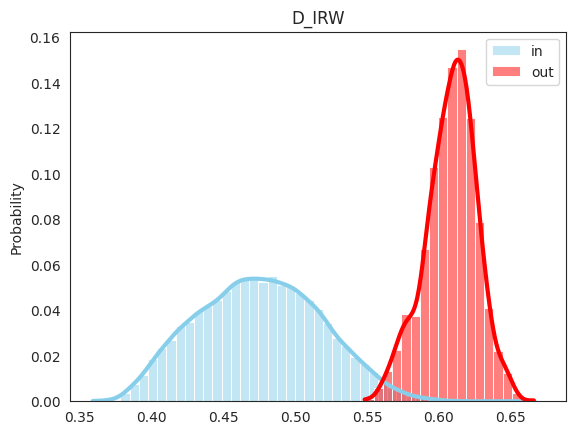

In [11]:
c = 2*np.max(np.concatenate((scores_ood, scores_test)))
sns.histplot(c-scores_test, label='in', binwidth=6.4e-3, color='skyblue',kde=True, stat='probability',  line_kws={"lw":3})
sns.histplot(c-scores_ood, label='out',binwidth=6.4e-3, color='red', kde=True, stat='probability',  line_kws={"lw":3})
plt.legend()
plt.title("D_IRW")
plt.show()

In [12]:
from _ood_classifier import OODDetector

In [23]:
tau=50
clf_0 = OODDetector(tau=tau, similarity='mahalanobis')
clf_1 = OODDetector(tau=tau, similarity='mahalanobis')

In [24]:
clf_0.fit(train_distrib[0])
clf_1.fit(train_distrib[1])

In [25]:
(clf_1.score(X_1, y_1)+clf_0.score(X_0, y_0))/2

0.9878325382885362

In [9]:
X_0 =  np.concatenate((ood_distrib[0], test_distrib[0]))
y_0 =   np.concatenate((np.ones((ood_distrib[0].shape[0])), np.zeros((test_distrib[0].shape[0]))))

X_1 =  np.concatenate((ood_distrib[1], test_distrib[1]))
y_1 =   np.concatenate((np.ones((ood_distrib[1].shape[0])), np.zeros((test_distrib[1].shape[0]))))

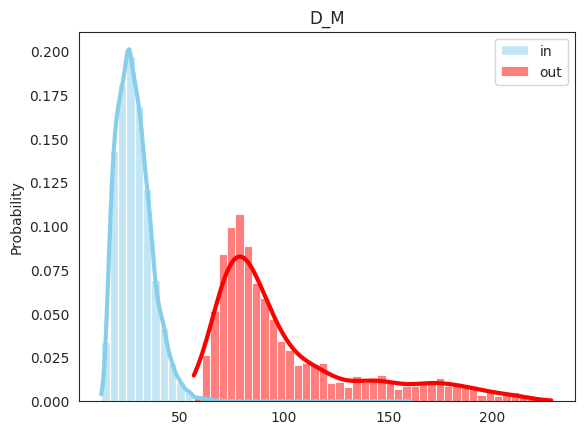

In [ ]:
#Maha
binwidth = 4
sns.histplot(scores_test, label='in', binwidth=binwidth, color='skyblue',kde=True, stat='probability',  line_kws={"lw":3})
sns.histplot(scores_ood, label='out',binwidth=binwidth, color='red', kde=True, stat='probability',  line_kws={"lw":3})
plt.legend()
plt.title("D_M")
plt.show()

In [21]:
#import random search from sklearn
from sklearn.model_selection import RandomizedSearchCV
#import shuffle from sklearn
from sklearn.utils import shuffle

X_0, y_0 = shuffle(X_0, y_0)
X_1, y_1 = shuffle(X_1, y_1)

# Create the parameter grid based on the results of random search, tau follows a gaussian centered in 50 with std 10
param_grid = {
    'tau': np.random.normal(50, 10, 10), 
    'similarity': ['mahalanobis'],
    'base_distribution': [train_distrib[0]]
}

# Create a based model
clf = OODDetector(similarity='mahalanobis', tau=50, base_distribution=train_distrib[0])

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid,
                            cv = 3, n_jobs = -1, verbose = 0)


In [23]:
grid_search.fit(X_0, y_0)
print(grid_search.best_params_)

/Users/g0bel1n/opt/anaconda3/envs/nlpensae-env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'tau': 55.20475116736243, 'similarity': 'mahalanobis', 'base_distribution': array([[ 0.1655158 ,  0.19259338, -0.05701194, ..., -0.04087529,
         0.06450007,  0.27201617],
       [ 0.26176506,  0.13326405,  0.04254614, ..., -0.02392149,
         0.06750306,  0.20914446],
       [ 0.16050506, -0.07738341,  0.21776502, ..., -0.1432903 ,
        -0.04918719, -0.1345499 ],
       ...,
       [-0.07087212, -0.27570873,  0.08874413, ..., -0.14185995,
        -0.05530067, -0.18070912],
       [-0.13870718, -0.08804137, -0.18017988, ..., -0.1654126 ,
        -0.06333739, -0.11101169],
       [ 0.00867541, -0.23554574,  0.14202845, ..., -0.29557773,
        -0.16673136, -0.346024  ]], dtype=float32)}


In [24]:
grid_search.best_score_

0.9936194668102111